## Background

In Chapter 8 of the fastai text we train a collaborative filtering model that predicts movie ratings for users (who have not watched those movies yet). It's one way of asking the question: would this user like this movie given their interests and the movie's characteristics? The users' "interests" and the movies' "characteristics" are the latent factors that we train. The ratings (predictions) are the dot product between the user and movie latent factors. This dot product passes through the `sigmoid_range` function which squeezes the input values into output values within a given range. In the textbook, the range we use is `0` to `5.5`. We use `5.5` because the sigmoid function never reaches `1` so `5` * sigmoid would never reach `5` (the maximum movie rating). Overshooting by `0.5` solves this issue. `5.5` times sigmoid will be able to reach an output of `5` comfortably.

In this blog post I'll explore the question: how does model performance vary as `y_range` varies?

## Training without `y_range`

I think it makes sense to first explore the loss and output distribution when I don't set `y_range` when training a collaborative filtering model on the 100k subset of MovieLens. I'll reuse the code from the text to prepare the data and `DataLoaders` and use a weight decay of `0.1`:

In [34]:
from scipy.stats import anderson

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'movie', 'rating', 'timestamp'])
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', usecols=(0,1), names=('movie', 'title'), header=None)
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [2]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,815,Groundhog Day (1993),4
1,357,"Phantom, The (1996)",3
2,246,Blown Away (1994),3
3,311,Casablanca (1942),4
4,457,Immortal Beloved (1994),4
5,241,Titanic (1997),4
6,525,Independence Day (ID4) (1996),4
7,394,Cape Fear (1991),4
8,109,Dante's Peak (1997),3
9,334,Wolf (1994),2


In [3]:
learn = collab_learner(dls, n_factors=50, y_range=None)
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.257861,1.301678,00:13
1,1.071218,1.113060,00:12
2,0.989054,1.017373,00:11
3,0.856945,0.928325,00:12
4,0.848923,0.905493,00:12


I want to see the distribution of predictions for the training and validation set and understand how they vary. I'll create a helper function for that.

In [62]:
def plot_preds(preds, title):
  preds = pd.Series(preds)
  preds.hist();
  plt.title(f'{title} preds distribution')
  print('median:', preds.median())
  print('mean:', preds.mean())
  print('kurtosis: ', preds.kurtosis())
  print('skew: ', preds.skew())

  result = anderson(preds, dist='norm')
  print(f'Statistic: {result.statistic}')
  print(f'Critical values: {result.critical_values}')
  print(f'Significance levels: {result.significance_level}')

  cond = (preds < 1) | (preds > 5)
  print(f'% of preds outside of 1-5 range: {100*cond.sum()/cond.count():.2f}%')

In [13]:
preds, targ = learn.get_preds(dl=dls.valid)

In [14]:
# check loss---should be close to 0.905493
MSELossFlat()(preds, targ)

TensorBase(0.9055)

median: 3.4890234
mean: 3.4260304
kurtosis:  0.7783028
skew:  -0.58709365
Statistic: 71.65442338831053
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.93%


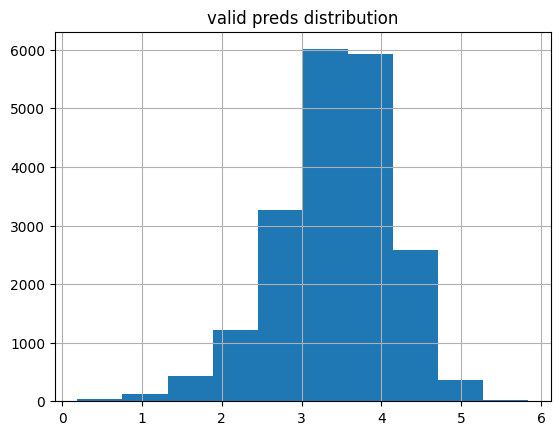

In [63]:
plot_preds(learn.get_preds(dl=dls.valid)[0], 'valid')

The validation set predictions are slightly skewed left with a median rating of about 3.5. Based on the Anderson-Darling statistic (which is significantly larger than the most stringent critical value of 1.092), these 20k samples don't come from a normal distribution. Less than 1% of the values fall outside of the expected rating range of 1 to 5.

median: 3.4968839
mean: 3.435657
kurtosis:  0.41849822
skew:  -0.49159753
Statistic: 228.91494857503858
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.68%


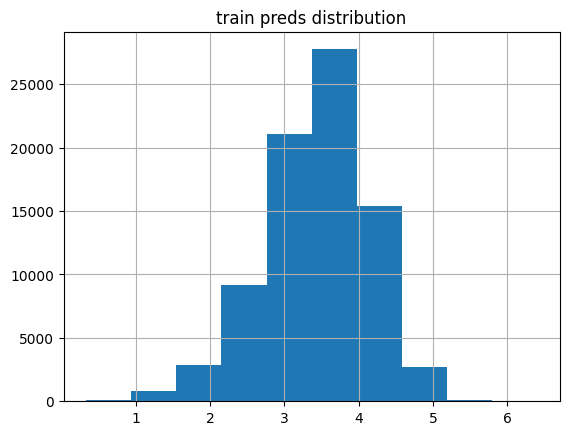

In [64]:
plot_preds(learn.get_preds(dl=dls.train)[0], 'train')

The training set predictions are similarly distributed, with a slightly larger peak resulting in a slightly larger median rating, still around 3.5.

In general there are more values outside of the realistic range (1 to 5) of ratings in the validation predictions than the training predicitons. Although, the model is doing pretty well at predicting values within the desired range with less than 1% falling outside this range.

## Training with `y_range=(0, 5.5)`

In [23]:
learn2 = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn2.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.882406,0.942118,00:13
1,0.650510,0.887792,00:12
2,0.542655,0.862130,00:12
3,0.440741,0.848899,00:12
4,0.442999,0.842771,00:12


Using a `y_range` of `0` to `5.5` resulted in a ~7% lower loss.

median: 3.5321503
mean: 3.4844122
kurtosis:  -0.055667587
skew:  -0.3875332
Statistic: 42.351315721156425
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.23%


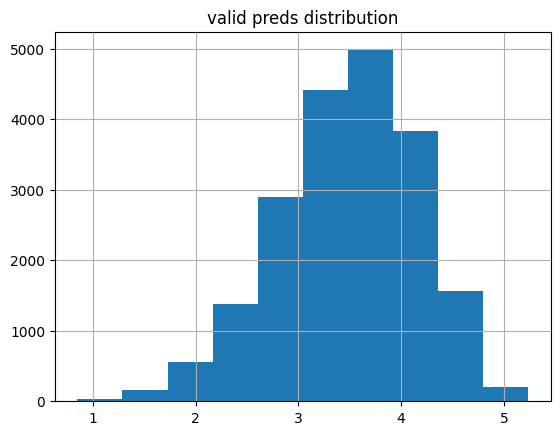

In [65]:
plot_preds(learn2.get_preds(dl=dls.valid)[0], 'valid')

This distribution is still not normal but has half the Anderson-Darling statistic as when `y_range` was `None`. The kurtosis is closer to 0 as well. The key point is that only about 1/4th of the values as before are outside of the 1-5 rating range.

median: 3.5977917
mean: 3.4933543
kurtosis:  0.14653848
skew:  -0.6128638
Statistic: 490.3643317096139
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.31%


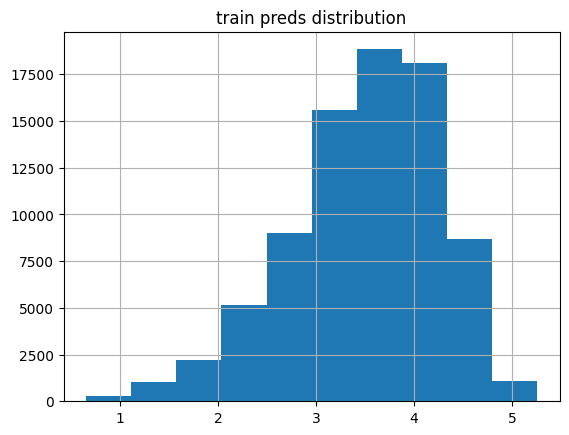

In [66]:
plot_preds(learn2.get_preds(dl=dls.train)[0], 'train')

The training predictions are more skewed than the validation predictions.

## Training with y_range=(0.5, 5.5)

In [54]:
ratings['rating'].min(), ratings['rating'].max()

(1, 5)

I can't find it anymore, but there was a fastai forums post where someone was questioning why the lower range in `y_range` wasn't `0.5` (`0.5` less than the minimum rating of `1` matching the upper range `5.5` is `0.5` more than the maximum rating of `5`). I'll see if training with `y_range=(0.5, 5.5)` improves the loss or changes the distribution of predictions.

In [55]:
learn3 = collab_learner(dls, n_factors=50, y_range=(0.5, 5.5))
learn3.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.841459,0.931699,00:14
1,0.652540,0.878996,00:12
2,0.530454,0.865976,00:12
3,0.448474,0.856127,00:13
4,0.423248,0.852660,00:12


That actually worsened the loss, increasing it by about 1%. I'll look at the training and validation prediction distributions:

median: 3.5413134
mean: 3.5004866
kurtosis:  -0.102446005
skew:  -0.3400191
Statistic: 33.359148298073706
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.21%


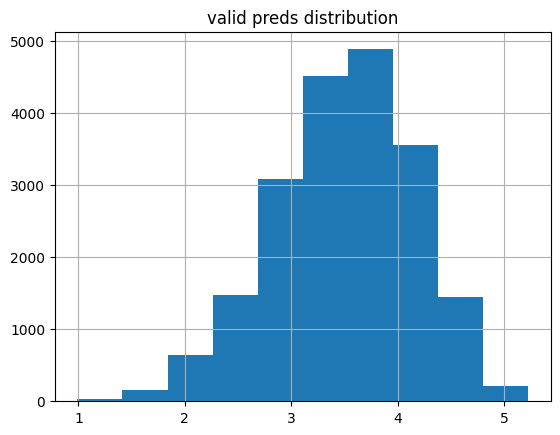

In [67]:
plot_preds(learn3.get_preds(dl=dls.valid)[0], 'valid')

The median and mean ratings are a bit higher and about the same amount of ratings are outside the acceptable range. The distribution is similarly not normal but has the lowest Anderson-Darling statistic so far.

median: 3.6018043
mean: 3.5078757
kurtosis:  0.0025408994
skew:  -0.5326863
Statistic: 388.08379248825077
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.23%


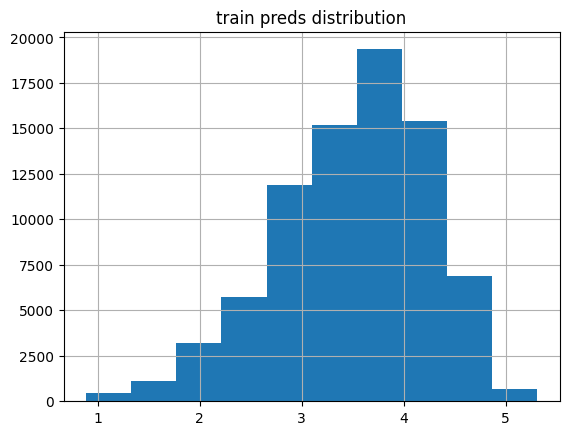

In [68]:
plot_preds(learn3.get_preds(dl=dls.train)[0], 'train')

The median and mean for the training predictions are also a tiny bit larger but mostly the distribution is the same as `y_range=(0, 5.5)` (although the kurtosis is much smaller).

## Training with `y_range=(0.75, 5.25)`

I'm curious if a "tighter" range changes the results.

In [71]:
learn4 = collab_learner(dls, n_factors=50, y_range=(0.75, 5.25))
learn4.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.891943,0.931708,00:12
1,0.676929,0.879818,00:13
2,0.531733,0.866186,00:12
3,0.459268,0.852890,00:13
4,0.454604,0.848512,00:12


This results in the second-best loss value thus far.

median: 3.5425978
mean: 3.5018144
kurtosis:  -0.113488525
skew:  -0.36151984
Statistic: 36.919869251567434
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.07%


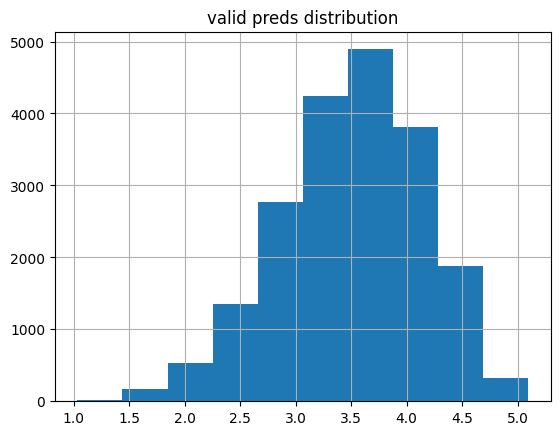

In [72]:
plot_preds(learn4.get_preds(dl=dls.valid)[0], 'valid')

median: 3.5998974
mean: 3.503809
kurtosis:  0.0028086598
skew:  -0.5607914
Statistic: 444.8073482159525
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.05%


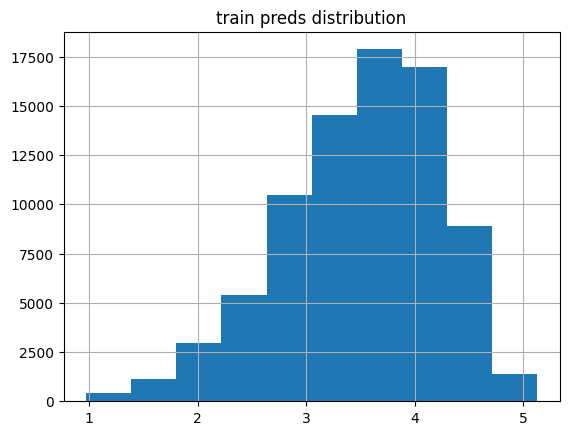

In [73]:
plot_preds(learn4.get_preds(dl=dls.train)[0], 'train')

The training and validation predictions have the lowest amount of predictions falling outside the acceptable range---this makes sense because sigmoid is not going to get as close to 1 and 5 as a `y_range` of `(0.5, 5.5)` or `(0, 5.5)`.

## Training with `y_range=(1, 5)`

Just to cover my bases, I'll train with a `y_range` not recommended: from 1 to 5. With this range, sigmoid will never output ratings of exactly 1 or 5.

In [74]:
learn5 = collab_learner(dls, n_factors=50, y_range=(1, 5))
learn5.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.890540,0.942143,00:13
1,0.675952,0.874900,00:12
2,0.560956,0.855053,00:14
3,0.500103,0.847492,00:17
4,0.492499,0.844006,00:14


Surprisingly, this has supplanted `y_range=(0.75, 5.25)` with the second-best loss after 5 epochs. I wonder if that is because the overall range is lower?

median: 3.5273356
mean: 3.489109
kurtosis:  -0.14329968
skew:  -0.37828833
Statistic: 42.07929809941925
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.00%


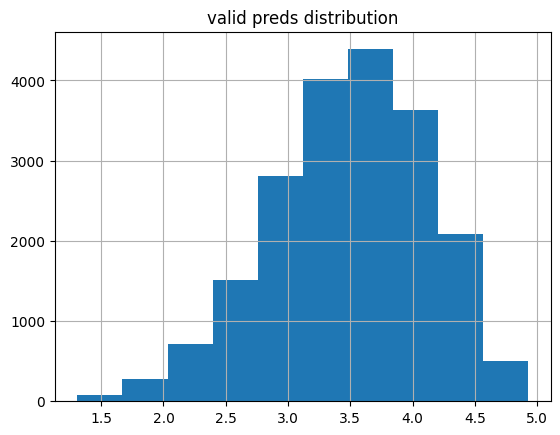

In [75]:
plot_preds(learn5.get_preds(dl=dls.valid)[0], 'valid')

As expected, 0.00% of the ratings fall outside of the minimum of 1 and maximum of 5.

median: 3.5868726
mean: 3.4960902
kurtosis:  -0.0628498
skew:  -0.55758834
Statistic: 467.5922112545086
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 0.00%


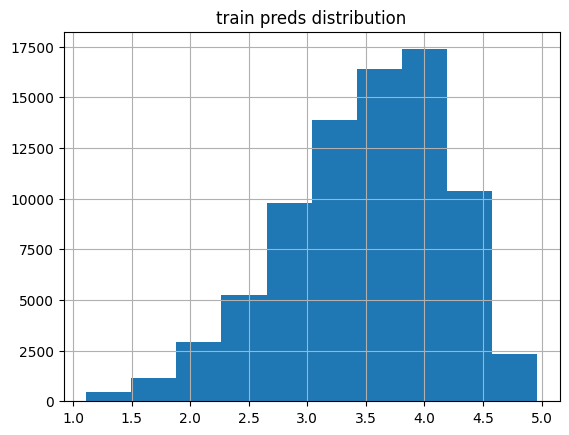

In [76]:
plot_preds(learn5.get_preds(dl=dls.train)[0], 'train')

## Training with `y_range=(-2, 8)`

As a last fun experiment, I'll use a much-wider-than-needed `y_range` and see how that affects the loss as well as the prediction distributions.

In [59]:
learn6 = collab_learner(dls, n_factors=50, y_range=(-2, 8))
learn6.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.806267,0.923924,00:13
1,0.556011,0.928603,00:14
2,0.437159,0.907485,00:13
3,0.346756,0.900347,00:12
4,0.331412,0.895803,00:13


Interestingly, the training loss is significantly lower than any of the other training runs. The validation loss is about 5% higher than the lowest validation loss achieved prior. I'm curious to see how the distributions compare.

median: 3.5484176
mean: 3.5100946
kurtosis:  0.11679816
skew:  -0.32186633
Statistic: 21.7676292314718
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 1.19%


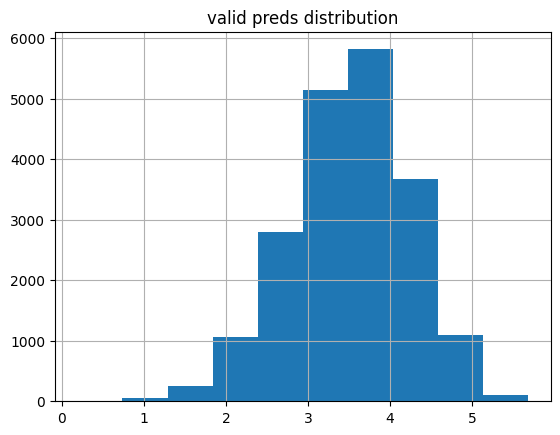

In [69]:
plot_preds(learn6.get_preds(dl=dls.valid)[0], 'valid')

About 6 times as many predictions fall outside of the acceptable range (~1.2% to ~0.2%) which makes sense since the `y_range` is wider. The overall distributions is similar to the other validation predictions although this distribution (still very not normal) has the lowest Anderson-Darling statistic.

median: 3.632931
mean: 3.5240762
kurtosis:  0.015062247
skew:  -0.50895566
Statistic: 350.41688774364593
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
% of preds outside of 1-5 range: 1.85%


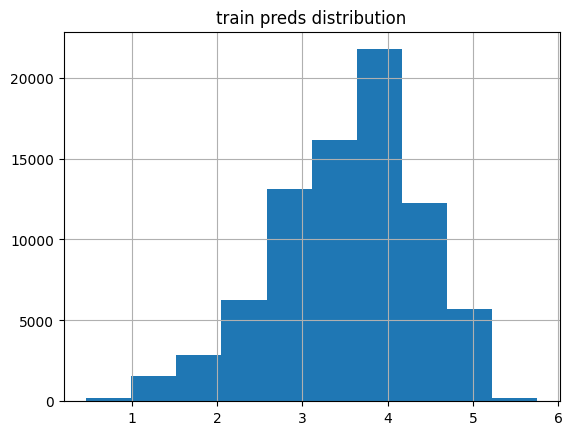

In [70]:
plot_preds(learn6.get_preds(dl=dls.train)[0], 'train')

The training loss distribution looks funkier than before (more than 10x the Anderson-Darling statistic), and it has a slightly larger median, and almost 9 times the values falling outside of the acceptable range.

## Final Thoughts

I ended up enjoying this experiment more than I expected to. It was helpful to see intuitive results being validated through observing the actual prediction distributions (for example, `y_range=(1,5)` had 0 prediction outside of that range while `y_range=(-2,8)` had the most.

There were some surprises along the way: a `y_range` of `(-2,8)` had the lowest training loss---not sure what to make of that---a `y_range` of `(1,5)` resulted in the second-best loss (perhaps because there is a smaller range to predict within?) and although the none of distributions were normal, there were varying degrees of non-normality.

As part of the fastai Part 1 Lesson 7 homework, I'll be training models on the full MovieLens dataset (~25M rows) so it'll be fun to experiment with `y_range` values and see if I get different results.

I hope you enjoyed this blog post!